In [1]:
import matplotlib.pyplot as plt
from ase.build import graphene
from ase.io import write
import ase
from PIL import Image
import cv2
import numpy as np
import ase.build
import abtem

In [2]:
import abtem
print(abtem.__version__)

# 检查 FlexibleAnnularDetector 是否可用
detector = abtem.FlexibleAnnularDetector(inner=50, outer=200)
print(detector)

1.0.6


In [3]:
# device: gpu or cpu
abtem.config.set({"device": "gpu", "fft": "fftw"})

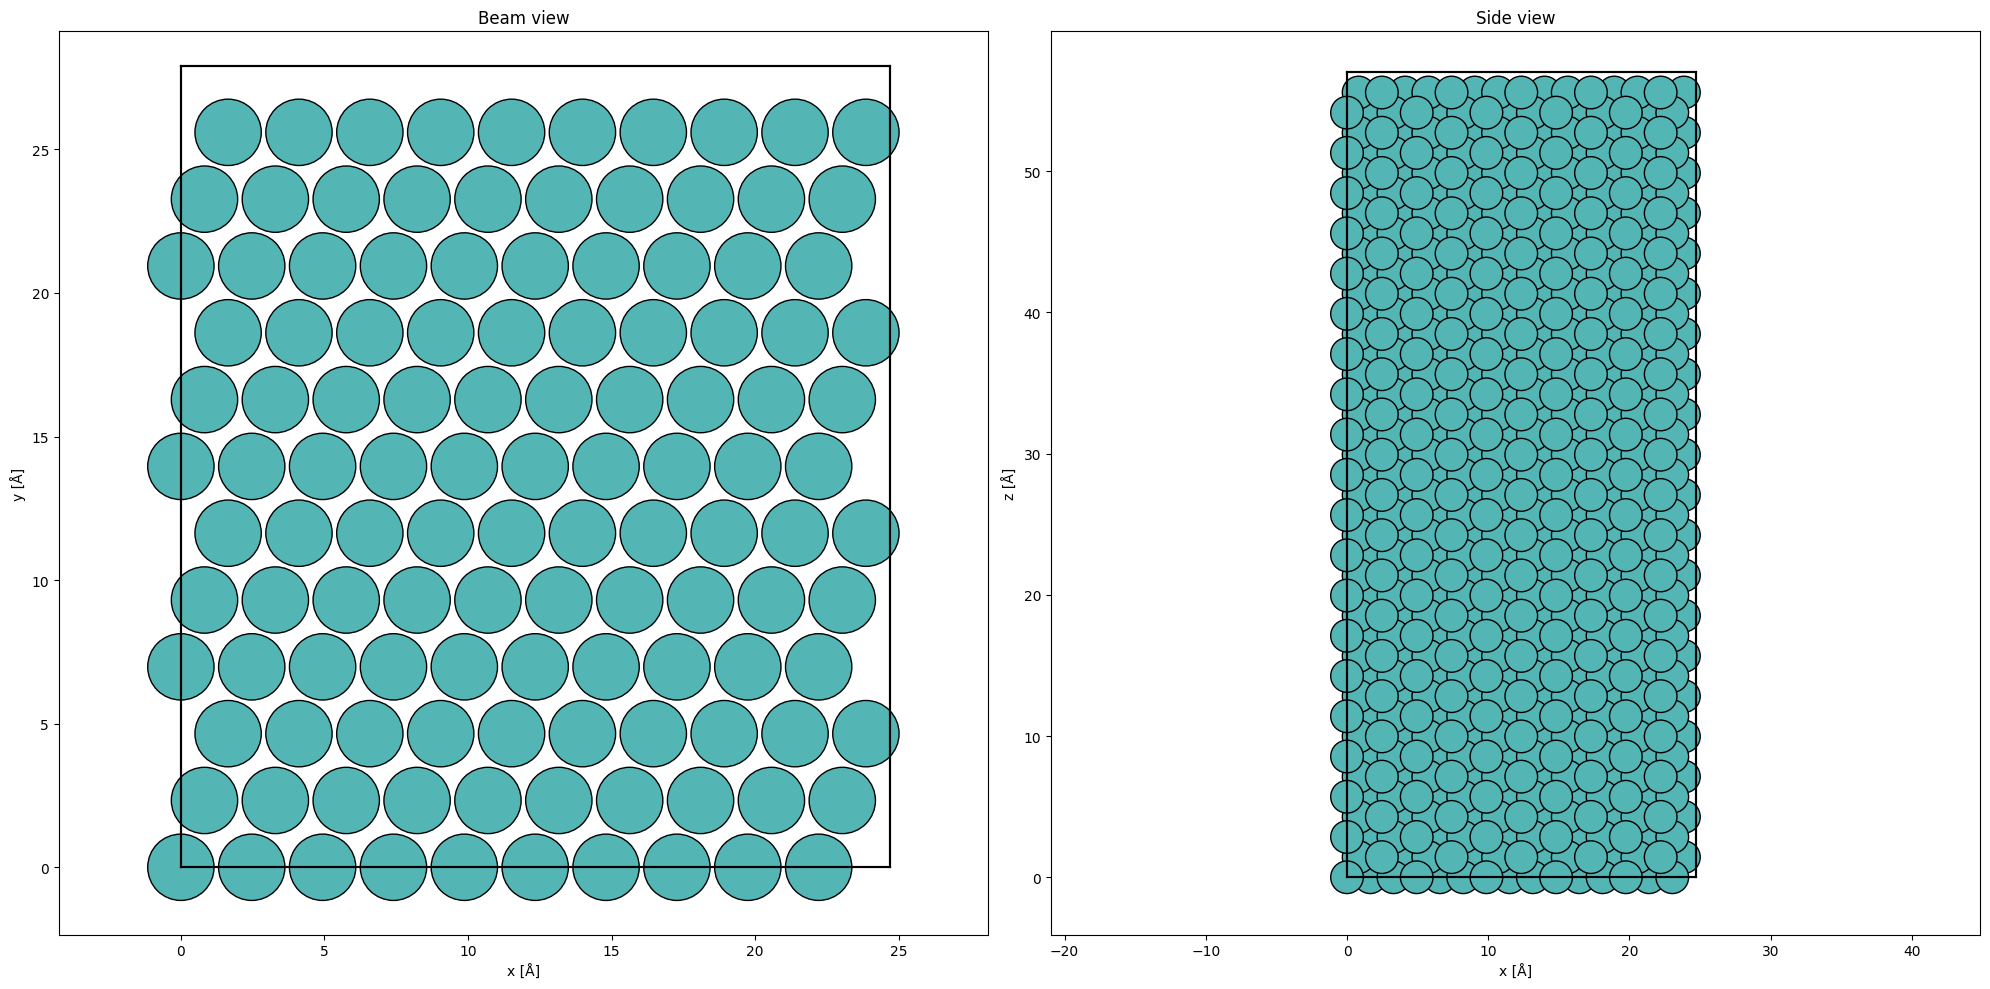

In [4]:
# 输入模型路径
model = ase.io.read('cif/Mo/POSCAR-603.cif', format='cif')
# indices：晶面
face = ase.build.surface(model, indices=(1, 0, 0), layers=1, periodic=True)


# 长宽高
length = 5
width = 4
height = 20

repeated_face = face * (length, width, height)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
abtem.show_atoms(repeated_face, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_face, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

In [26]:
frozen_phonons = abtem.FrozenPhonons(repeated_face, 8, sigmas=0.1)

In [27]:
# potential = abtem.Potential(frozen_phonons, sampling=0.05)
potential = abtem.Potential(frozen_phonons, sampling=0.05)

In [54]:
probe = abtem.Probe(energy=300e3, semiangle_cutoff=20,Cs=10e4, defocus="scherzer")
probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

defocus = 54.3426474756167 Å
FWHM = 0.49855756759643555 Å


[########################################] | 100% Completed | 109.39 ms
[########################################] | 100% Completed | 110.62 ms


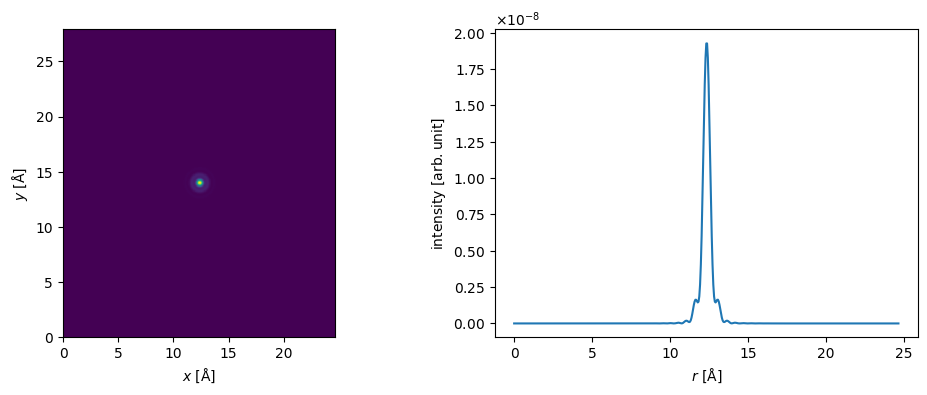

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

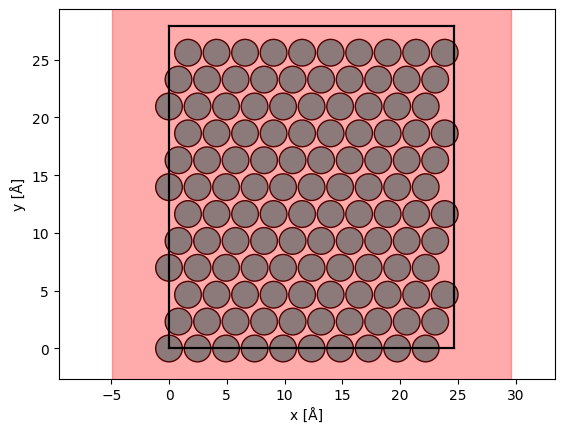

In [56]:
grid_scan = abtem.GridScan(
    start=(-0.2, -0.2),
    end=(1.2, 1.2),
    sampling=probe.aperture.nyquist_sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(repeated_face)

grid_scan.add_to_plot(ax)

In [57]:
detector =abtem.detectors.FlexibleAnnularDetector(inner=0, outer=150)

In [ ]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=detector)

flexible_measurement.compute()

[########################                ] | 62% Completed | 48m 27ss

In [ ]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 100)
haadf_measurement = flexible_measurement.integrate_radial(70, 120)

In [ ]:
measurements = abtem.stack(
    [bf_measurement, maadf_measurement, haadf_measurement], ("BF", "MAADF", "HAADF")
)

measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
)

In [ ]:
interpolated_measurements = measurements.interpolate(0.05)

interpolated_bf_measurements = bf_measurement.interpolate(0.05)
interpolated_maadf_measurements = maadf_measurement.interpolate(0.05)
interpolated_haadf_measurements = haadf_measurement.interpolate(0.05)

In [ ]:
filtered_measurements = interpolated_measurements.gaussian_filter(0.3)

filtered_bf_measurements = interpolated_bf_measurements.gaussian_filter(0.3)
filtered_maadf_measurements = interpolated_maadf_measurements.gaussian_filter(0.3)
filtered_haadf_measurements = interpolated_haadf_measurements.gaussian_filter(0.3)

In [ ]:
filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

In [ ]:
dose_area = 1e7

noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=dose_area)

noisy_bf_measurements = filtered_bf_measurements.poisson_noise(dose_per_area=dose_area)
noisy_maadf_measurements = filtered_maadf_measurements.poisson_noise(dose_per_area=dose_area)
noisy_haadf_measurements = filtered_haadf_measurements.poisson_noise(dose_per_area=dose_area)


noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
)

save_path_temp = 'temp.jpg'
save_path = 'surface_001.jpg'
plt.savefig(save_path_temp, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#重新读取并调整
read_image = Image.open(save_path_temp).convert('L')
read_image.save(save_path)

In [ ]:
noisy_bf_measurements.show()
plt.axis('off')

save_path_temp = 'temp.jpg'
save_path = 'bf.jpg'
plt.savefig(save_path_temp, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#重新读取并调整
read_image = Image.open(save_path_temp).convert('L')
read_image.save(save_path)

In [ ]:
noisy_maadf_measurements.show()
plt.axis('off')

save_path_temp = 'temp.jpg'
save_path = 'maadf.jpg'
plt.savefig(save_path_temp, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#重新读取并调整
read_image = Image.open(save_path_temp).convert('L')
read_image.save(save_path)

In [ ]:
noisy_haadf_measurements.show()
plt.axis('off')

save_path_temp = 'temp.jpg'
save_path = 'haadf.jpg'
plt.savefig(save_path_temp, dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

#重新读取并调整
read_image = Image.open(save_path_temp).convert('L')
read_image.save(save_path)

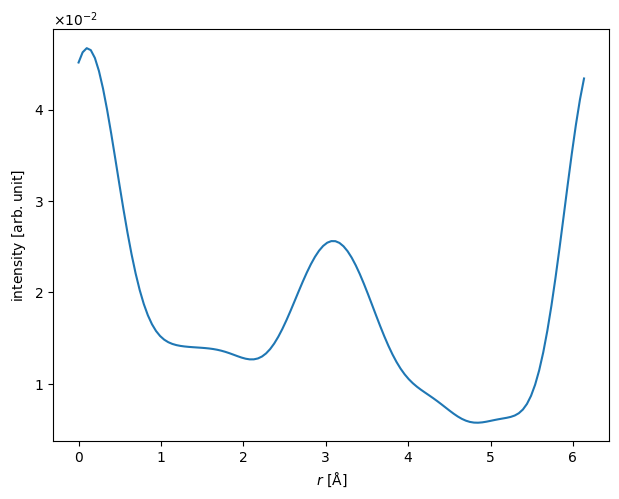

In [25]:
line_profile = filtered_measurements.interpolate_line(
    start=(1 / 2, 0), end=(1 / 2, 1), fractional=True
)

line_profile[-1].show();